# SQL User Segmentation (RFM-Based)

This notebook segments users based on Recency, Frequency, and a Monetary proxy (RFM) using SQL.  
The segmentation identifies user behavior patterns and categorizes users into groups such as Loyal Users, One-Time Shoppers, Champions, and more.

**Data used:**  
- `orders_cleaned.csv` – contains cleaned user order metadata  
- `joined_order_products.csv` – includes user-item-level prior purchases

In [16]:
import pandas as pd
import sqlite3

conn = sqlite3.connect(":memory:")

orders = pd.read_csv("../data/processed/orders_cleaned.csv")
order_products = pd.read_csv("../data/processed/joined_order_products.csv")

orders.to_sql("orders", conn, index=False, if_exists="replace")
order_products.to_sql("order_products", conn, index=False, if_exists="replace");

In [17]:
cursor = conn.cursor()

print("Creating indexes...")
cursor.execute("CREATE INDEX IF NOT EXISTS idx_orders_user_id ON orders (user_id);")
cursor.execute("CREATE INDEX IF NOT EXISTS idx_orders_order_id ON orders (order_id);")
cursor.execute("CREATE INDEX IF NOT EXISTS idx_order_products_order_id ON order_products (order_id);")

conn.commit()
print("Indexes created successfully.");

Creating indexes...
Indexes created successfully.


## Generate User Segments Based on RFM Criteria

In [19]:
query = '''
-- Step 1a: Calculate product count for each order
WITH order_item_counts AS (
    SELECT
        oo.user_id,
        oo.order_id,
        COUNT(*) AS items_in_order
    FROM order_products opp
    JOIN orders oo ON oo.order_id = opp.order_id
    GROUP BY oo.user_id, oo.order_id
),
-- Step 1b: Calculate average basket size for each user
user_avg_basket AS (
    SELECT
        user_id,
        AVG(items_in_order) AS avg_basket_size
    FROM order_item_counts
    GROUP BY user_id
),
-- Step 1c: Aggregate other user-level metrics (Recency and Frequency)
user_rf_metrics AS (
    SELECT
        o.user_id,
        MAX(o.order_number) AS frequency, -- Total number of orders for the user
        AVG(o.days_since_prior_order) AS recency -- Average days between orders; lower is better
    FROM orders o
    GROUP BY o.user_id
),
-- Step 1d: Combine all user metrics
user_summary AS (
    SELECT
        rf.user_id,
        rf.frequency,
        rf.recency,
        COALESCE(uab.avg_basket_size, 0) AS avg_basket_size -- Use 0 if no basket size found
    FROM user_rf_metrics rf
    LEFT JOIN user_avg_basket uab ON rf.user_id = uab.user_id
),
-- Step 2: Score users based on RFM metrics
scored_users AS (
    SELECT
        user_id,
        frequency,
        recency,
        avg_basket_size,
        NTILE(4) OVER (ORDER BY frequency DESC) AS f_score,       -- f_score: 4 = highest freq, 1 = lowest
        NTILE(4) OVER (ORDER BY recency ASC) AS r_score,          -- r_score: 1 = best recency (lowest avg days), 4 = worst
        NTILE(4) OVER (ORDER BY avg_basket_size DESC) AS m_score  -- m_score: 4 = highest avg basket, 1 = lowest
    FROM user_summary
    WHERE user_id IS NOT NULL -- Ensure user_id is not null before segmentation
)
-- Step 3: Assign segment labels based on scores
SELECT
    user_id,
    frequency,
    recency,
    avg_basket_size,
    f_score,
    r_score,
    m_score,
    CASE
        WHEN f_score >= 3 AND r_score >= 3 AND m_score >= 3 THEN 'Champions'
        WHEN f_score >= 3 AND r_score >= 2 THEN 'Loyal Users'
        WHEN f_score = 1 AND r_score = 1 THEN 'One-Time Shoppers'
        WHEN r_score <= 2 AND f_score >= 3 THEN 'At-Risk Loyalists' -- Good Recency (low r_score), Good Frequency
        ELSE 'Others'
    END AS segment_label
FROM scored_users;
'''

user_segments = pd.read_sql_query(query, conn)

print("First 5 segmented users:")
print(user_segments.head())

First 5 segmented users:
   user_id  frequency  recency  avg_basket_size  f_score  r_score  m_score  \
0    46408        100     0.23         8.622642        1        1        3   
1   134572        100     0.29         7.074074        1        1        3   
2   112044        100     0.42        19.178571        1        1        1   
3    54485        100     0.47        19.000000        1        1        1   
4   100787        100     0.54        20.703704        1        1        1   

       segment_label  
0  One-Time Shoppers  
1  One-Time Shoppers  
2  One-Time Shoppers  
3  One-Time Shoppers  
4  One-Time Shoppers  


In [18]:
segment_summary = user_segments['segment_label'].value_counts().reset_index()
segment_summary.columns = ['segment_label', 'user_count']

segment_summary.to_csv("../data/processed/user_segments_summary.csv", index=False)

print("\nUser Segments Summary:")
print(segment_summary)


User Segments Summary:
       segment_label  user_count
0             Others       74345
1        Loyal Users       51454
2          Champions       37712
3  One-Time Shoppers       28760
4  At-Risk Loyalists       13938


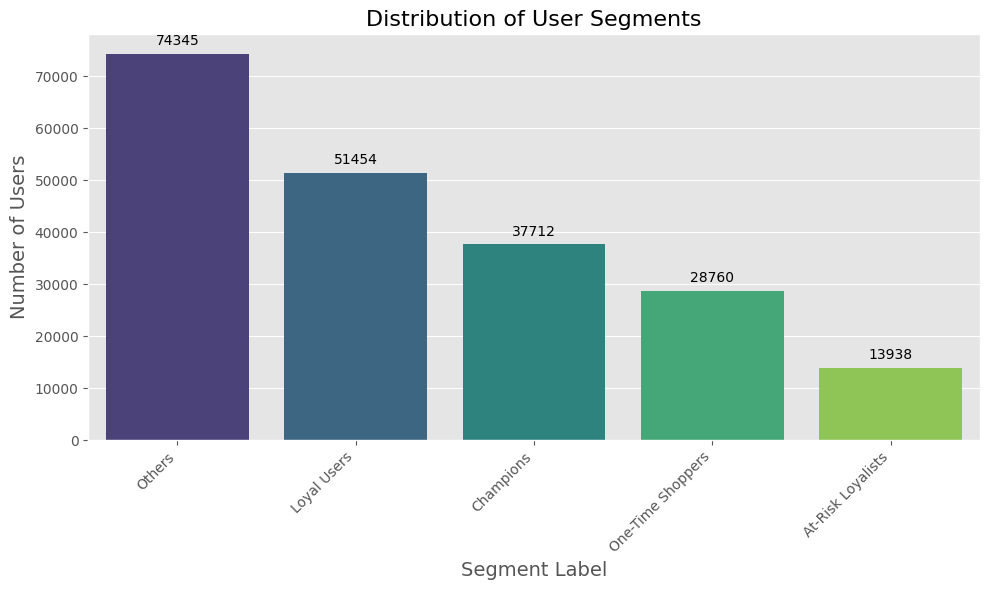

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    x='segment_label',
    y='user_count',
    data=segment_summary,
    hue='segment_label', 
    palette='viridis',
    order=segment_summary.sort_values('user_count', ascending=False).segment_label,
    legend=False,      
    dodge=False         
)

plt.title('Distribution of User Segments', fontsize=16)
plt.xlabel('Segment Label', fontsize=14)
plt.ylabel('Number of Users', fontsize=14)
plt.xticks(rotation=45, ha='right')

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9),
                     textcoords = 'offset points')

plt.tight_layout()
plt.show();

## Notes

- **RFM Definitions:**
  - `Recency` is calculated as the average days since prior order (lower is better).
  - `Frequency` is the total orders made by a user (specifically, the maximum `order_number`).
  - `Monetary proxy` is simulated by the average basket size (average number of products per order; higher is better).

- **Scoring:**
  - `NTILE(4)` scoring was used to rank users relative to each R, F, M component. Quartiles are assigned scores 1-4.
    - `f_score`: 4 for top 25% frequency, 1 for bottom 25%.
    - `r_score`: 1 for top 25% recency (lowest average days since prior order), 4 for bottom 25%. (Note: lower `recency` value is better, hence `ASC` in `NTILE` for `r_score` means a score of 1 is best).
    - `m_score`: 4 for top 25% average basket size, 1 for bottom 25%.

- **Performance Optimization for Large Datasets:**
  - Due to the potential size of the dataset, SQL indexes were created on key columns (`user_id` in `orders`, `order_id` in both `orders` and `order_products`) before running the main segmentation query. This significantly improves query performance for joins and aggregations.

- **Segmentation Logic:**
  - The segment labels (e.g., 'Champions', 'Loyal Users') are assigned based on the R, F, and M scores using a `CASE` statement in the SQL query.
  - **Important**: Review the segment definitions in the SQL `CASE` statement if the resulting segments (e.g., 'Champions' potentially having worse recency scores based on the `r_score` interpretation) are not aligned with your business definitions or typical RFM interpretations. For instance, 'Champions' are currently defined with `r_score >= 3`, which, given `NTILE(4) OVER (ORDER BY recency ASC)`, means they are in the 50th-100th percentile for *average days since prior order* (i.e., potentially worse recency). Adjust the `CASE` statement conditions as needed for your specific business logic.

- **Visualization:**
  - A bar plot is generated using `matplotlib` and `seaborn` to visualize the distribution of users across the different segments. This helps in understanding the relative sizes of each user group.

These segment labels and their understanding are intended for use in subsequent behavioral and marketing analyses.